## Import modules/scripts and optimize portfolio weights:

In [25]:
from datetime import date, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import numpy as np
import torch

from JSONReader import read_json
from cov_matrix import MPTCovMat
from allocator import WeightOptimizer
from backtesting import BackTester

### Set desired parameters

In [26]:
# ---------- OPTIMIZATION ----------
train_start = date(2022,1,1)
train_end = date(2023,12,31)

#loss function:
alpha = 0.3 #calmar
beta = 0.1 #omega
gamma = 0.6 #sortino

#target:
rf = 0.027 #risk free rate (can be used as target rate instead)
rf_period = timedelta(120) #number of days for risk free, e.g. 365 for annual 

num_iter = 10000 #number of weight update iterations

# ---------- COMPARISON ---------- 
test_start=date(2024,1,1)
test_end=date(2024,12,31 )
comparison_ticker = '^OMX' #ticker of index to compare against


### Optimize weights

In [27]:
ticker_list = read_json('assets.json')
tickers = yf.Tickers(ticker_list)

#get data
data = MPTCovMat(tickers=tickers,start=train_start,end=train_end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]

allocator = WeightOptimizer(lr=1e-3,num_assets=len(asset_names),risk_free=rf,risk_free_period=rf_period,num_iter=num_iter)
cos_losses, pf_daily_returns = allocator.optimize_weights(alpha,beta,gamma, returns=torch.tensor(returns.values))
weights = pd.DataFrame(allocator.alloc_weights.numpy(force=True), index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

[*********************100%***********************]  30 of 30 completed


Optimizing weights... 
Ticker
ABB.ST          6.084846
ALFA.ST         3.341258
ASSA-B.ST       2.222366
ATCO-A.ST       3.590988
ATCO-B.ST       1.359527
AZN.ST          2.374243
BOL.ST          1.066766
ELUX-B.ST       0.398848
ERIC-B.ST       0.705404
ESSITY-B.ST     0.658064
EVO.ST          1.395344
GETI-B.ST       0.543713
HEXA-B.ST       0.755278
HM-B.ST         3.972915
INVE-B.ST      36.125610
KINV-B.ST       0.087249
NDA-SE.ST       0.186932
NIBE-B.ST       0.421817
SAAB-B.ST      16.736446
SAND.ST         0.184068
SBB-B.ST        0.669223
SCA-B.ST        1.166507
SEB-A.ST        2.075897
SHB-A.ST        2.275169
SINCH.ST        0.973309
SKF-B.ST        1.193730
SWED-A.ST       2.043805
TEL2-B.ST       1.242879
TELIA.ST        1.016526
VOLV-B.ST       5.131273
Name: Weights %, dtype: float32


### Plot sharpe ratios to number of iterations

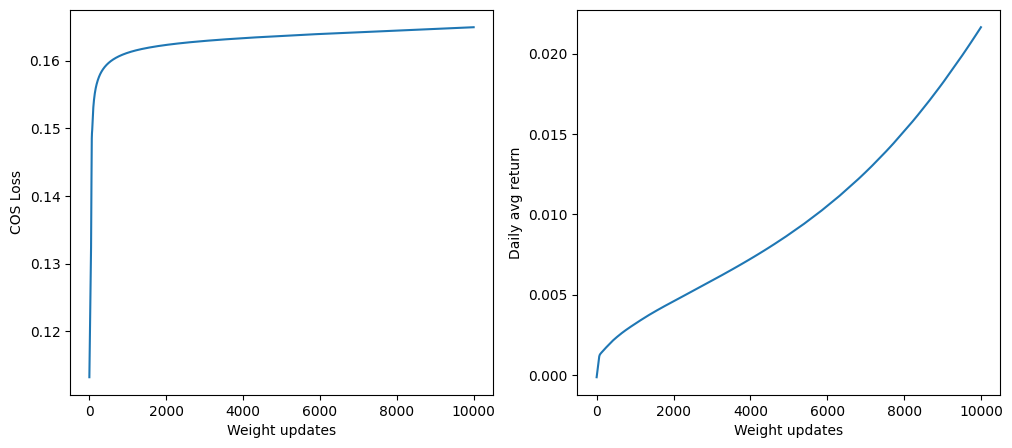

In [28]:
x_df = pd.DataFrame(range(0,num_iter))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(x_df,cos_losses.numpy(force=True),)
ax1.set_xlabel('Weight updates')
ax1.set_ylabel('COS Loss')
ax2.plot(x_df,pf_daily_returns.numpy(force=True),)
ax2.set_xlabel('Weight updates')
ax2.set_ylabel('Daily avg return')
plt.show()

## Backtesting

### Get comparison data

In [29]:
tester = BackTester(test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)
comp_data = yf.Ticker(comparison_ticker).history(start=test_start,end=test_end,auto_adjust=True)
comp_returns:pd.DataFrame = np.log(comp_data['Close']/comp_data['Close'].shift(1))
comp_returns.dropna(inplace=True)
comp_cumulative = (comp_returns+1).cumprod(0)-1

[*********************100%***********************]  30 of 30 completed


TESTING


### Plot  results

Comparison portfolio return: 2.88 %
Optimized portfolio return: 23.43 %
Percentage point difference: 20.55 pp
Percentage difference: 713.54 %


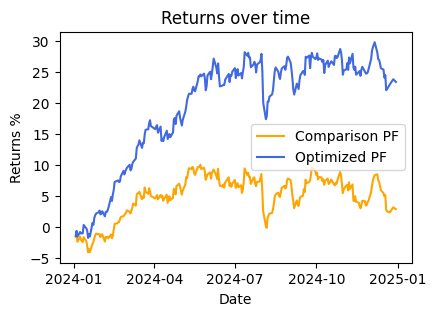

In [30]:
comp_returns = pd.DataFrame(comp_cumulative)
test_returns = tester.cumulative_returns(tester.test_portfolio_returns)
ax1=plt.subplot(1,2,1)
ax1.set_title('Returns over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2,maxticks=6))
ax1.plot(comp_returns.mul(100),color='orange')
ax1.plot(test_returns.mul(100),color='royalblue')
ax1.legend(['Comparison PF','Optimized PF'])
comp_final_return = round((comp_returns.iloc[-1].values*100).item(),2)
optimized_final_return = round((test_returns.iloc[-1,:].values*100).item(),2)
comp_optim_diff = optimized_final_return-comp_final_return
perc_diff = round(((optimized_final_return/comp_final_return)-1)*100,2)

print(f'Comparison portfolio return: {str(comp_final_return)+' %'}')
print(f'Optimized portfolio return: {str(optimized_final_return)+' %'}')
print(f'Percentage point difference: {round(comp_optim_diff,2)} pp')
print(f'Percentage difference: {round(((optimized_final_return/comp_final_return)-1)*100,2)} %')